In this post, we will take a look at Nyström approximation, a technique that I came across in [Nyströmformer: A Nyström-based Algorithm for Approximating Self-Attention](https://arxiv.org/pdf/2102.03902.pdf) by Xiong et al. This is yet another interesting paper that seeks to make the self-attention algorithm more efficient down to linear runtime. While there are many intricacies to the Nyström method, the goal of this post is to provide a high level intuition of how the method can be used to approximate large matrices, and how this method was used in the aforementioned paper. 

# Concept

Despite its fancy and somewhat intimidating name, the Nyström method has an intuitive explanation. The idea is that, if we know the distance between point A and point B, as well as that between point B and point C, then we can approximate the distance between points A and C as some sort of addition of the two quantities. Of course, if we were discussing distances in the context of one-dimensional space, namely the real number line, we would not only be able to approximating the distance; we would know the exact quantity. However, in high-dimensional space, this is somewhat more difficult, and we can only resort to approximations.

To put things into context, let's say we want to approximate the attention matrix in the transformer architecture. The Nyström method begins by selecting what the authors of the paper refer to as landmarks. Basically, if we have an attention matrix $A \in \mathbb{R}^{L \times L}$, then we select a few landmark rows and columns to use as the basis or pivot point for our approximation. The goal, then, is to select as few landmarks as possible while being able to approximate the attention matrix as accurately as possible.

For sake of simplicity, let's say we select the first row and column to be our landmarks. Then, the goal is to approximate the inner sub-matrix $A_\text{sub} \in \mathbb{R}^{(L - 1) \times (L - 1)}$. How might we go about it?

As stated earlier, the intuition is that we use the landmarks as pivot points. Since we selected the first rows and columns as our landmarks, we have access to $q_1 k_n^\top \forall n \leq L$, as well as $q_n k_1\top \forall n \leq L$ (for simplicity, we ignore the normalizing square root). If we remind ourselves of the motivation behind the transformer's key-value-query architecture, we can consider attention as a way of calculating the distance or relevance between pairs of tokens in a given sequence. Put differently, the landmarks tell us the distance between the first query and all other keys, as well as the distance between the first key and all other queries.

Without loss of generality, we can approximate the distance between any $i$th key and the $j$th query using these landmarks. The way we do this is somewhat similar to the point A, B, C example we briefly discussed earlier. Namely, we start by looking at the distance between the $i$th key and the first query. Then, we also look at the attention value between the first key and the $j$th query. Note that connecting the two dots kind of gives us a sense of how related the $i$th query and $j$ query are. To remove the redundancy, we divide the product by the self-attention of the first token, or the attention score between the first key and query. 

$$
A_{ij} = \frac{q_i k_1^\top \cdot q_1 k_j^\top}{q_1 k_1^\top} \tag{1}
$$

Of course, if we have multiple landmarks, we can easily expand the expression above into matrix form. The tilde indicates landmark rows and columns.

$$
\tilde{A} = Q \tilde{K}^\top \times (\tilde{Q} \tilde{K}^\top)^\star \times \tilde{Q} K \tag{2}
$$

The star expression ($\star$) denotes the Moore-Penrose pseudo-inverse.

Now that we have a general intuition of how Nyström approximation works in the context of attention, let's get into some basic implementation.

# Implementation

The goal here is to see that Nyström approximation can indeed yield reasonably accurate results, and that the larger the number of key landmarks, the better the approximation. Consider this as a form of Monte Carlo experiment. 

Let's begin by importing some modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format="retina"

For sake of simplicity, we assume a very basic model with a hidden dimension of 2, and some data points whose sequence length is 5. For simplicity, we omit the batch dimension.

Then, in the context of attention, we would end up with the following keys and query tensors, as well as a five-by-five square attention matrix.

In [4]:
d_model = 2
seq_len = 5

Q = np.random.randn(seq_len, d_model)
K = np.random.randn(seq_len, d_model)
A = Q @ K.T
A.shape

(5, 5)

The goal, then, is to approximate this square attention matrix.

In [5]:
A

array([[ 2.29571874, -0.7373519 ,  0.32730778, -0.84730782, -1.16558083],
       [ 1.4346883 , -0.32765206,  0.80095764, -0.39437617,  0.17889744],
       [ 1.38973136, -0.61066937, -0.53783773, -0.67968999, -1.82523199],
       [-1.80977456,  0.1036656 , -2.39735444,  0.18320197, -2.33569844],
       [ 1.36516091, -0.40695455,  0.33580143, -0.47186895, -0.47836287]])

Let's begin our approximation by assuming the worst case, in which we only have access to one landmark. This brings us to equation (1) where essentially all operations were done on vectors instead of matrices.

In [6]:
num_landmarks = 1

Q_tilde = Q[:num_landmarks]
K_tilde = K[:num_landmarks]

Recalling equations (1) and (2), we can now write the approximation of the attention matrix as follows. 

$$
\tilde{A} = Q \tilde{K}^\top \times (\tilde{Q} \tilde{K}^\top)^\star \times \tilde{Q} K
$$

In [7]:
A_tilde = (Q @ K_tilde.T) @ np.linalg.pinv(Q_tilde @ K_tilde.T) @ (Q_tilde @ K.T)
A_tilde.shape

(5, 5)

The dimensionality seems to match that of the original attention matrix, as expected. If we print out the approximation, we should expect to see exact matches in the first row and column; the rest of the four-by-four region of the matrix should roughly be similar to that of the original.

In [8]:
A_tilde

array([[ 2.29571874, -0.7373519 ,  0.32730778, -0.84730782, -1.16558083],
       [ 1.4346883 , -0.46080128,  0.20454799, -0.52951722, -0.72841901],
       [ 1.38973136, -0.44636176,  0.19813834, -0.51292444, -0.7055935 ],
       [-1.80977456,  0.58127361, -0.25802521,  0.66795471,  0.91885757],
       [ 1.36516091, -0.43847008,  0.19463525, -0.50385594, -0.69311861]])

We can indeed quickly verify that the first row and column are exact matches; however, the rest of the 16 elements are somewhat difficult to compare. We can more systematically calculate the difference between two matrices by using a norm, such as the Frobenius norm.

In [9]:
np.linalg.norm(A - A_tilde)

4.33185890598477

If we look at the raw value of the subtraction, we can see that the approximation isn't too bad.

In [10]:
A - A_tilde

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.22044605e-16,  1.33149223e-01,  5.96409654e-01,
         1.35141056e-01,  9.07316456e-01],
       [ 0.00000000e+00, -1.64307605e-01, -7.35976069e-01,
        -1.66765549e-01, -1.11963848e+00],
       [ 0.00000000e+00, -4.77608006e-01, -2.13932924e+00,
        -4.84752738e-01, -3.25455600e+00],
       [ 0.00000000e+00,  3.15155316e-02,  1.41166181e-01,
         3.19869853e-02,  2.14755744e-01]])

## Monte Carlo Approach

Let's extend this little trial with one landmark to larger matrices. For ease of execution and implementation, I've basically wrapped each step outlined above as functions. 

The first function, `norms_by_landmarks`, receives query and key matrices, then approximates the attention matrix while varying the number of landmarks. The Frobenius norm is used to measure how good the approximation is. Theoretically, we should expect to see a downward-sloping pattern.

In [12]:
def norms_by_landmarks(Q, K):
    result = []
    A = Q @ K.T
    for num_landmarks in range(1, len(Q) + 1):
        Q_tilde = Q[:num_landmarks]
        K_tilde = K[:num_landmarks]
        A_tilde = (Q @ K_tilde.T) @ np.linalg.pinv(Q_tilde @ K_tilde.T) @ (Q_tilde @ K.T)
        result.append(np.linalg.norm(A - A_tilde))
    return np.asarray(result)

The second function, `run_experiment`, is a wrapper around the first one. It repeatedly conducts the same experiment for a specified number of iterations. The purpose of repetition is essentially remove the possibility of luck, where some randomly initialized key and query matrices are configured in such a way that the Nyström approximation performs too well or poorly on a given task. By repeating the experiment and averaging the result---which is the spirit behind Monte Carlo approximations---we can have more confidence in our final result.

In [13]:
def run_experiments(d_model, seq_len, num_iter=10):
    result = 0
    for _ in range(num_iter):
        Q = np.random.randn(seq_len, d_model)
        K = np.random.randn(seq_len, d_model)
        norm = norms_by_landmarks(Q, K)
        result += norm
    return result / num_iter

Here, we assume a sequence length of 50, and the hidden size of the model (or the embedding size) to be 10. And off we go!

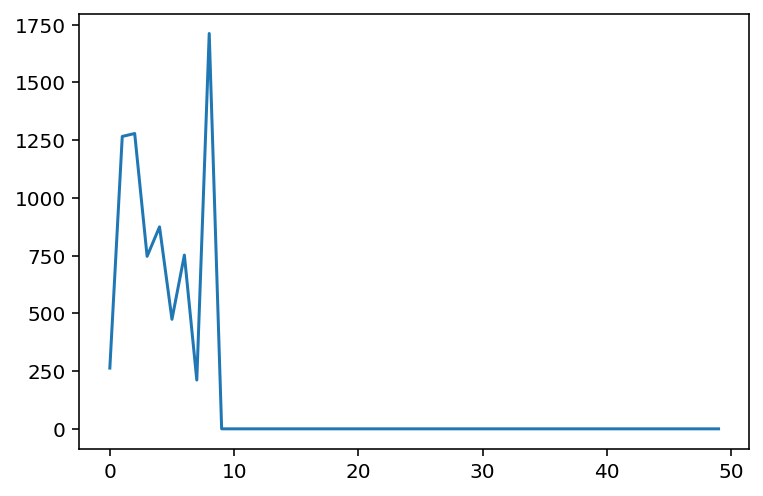

In [14]:
norms = run_experiments(d_model=10, seq_len=50)
plt.plot(range(len(norms)), norms)
plt.show()

# Conclusion

While there is some noise in the final outcome, we do see that beyond a certain dimension, the approximation yields near exact results. In this case, it seems to happen around 10 landmarks. 

Transformers have now taken over much of the ML world, even beyond NLP. Recently, I came across a paper titled [Pretrained Transformers are Universal Computation Engines](https://arxiv.org/abs/2103.05247). Apparently, pretrained transformer LMs can perform extremely well on tasks with minimal fine-tuning. Specifically, even if the feedforward and attention portion of the network frozen---which amounts to nearly 99 percent of the entire model architecture---transformer LMs can be micro-tuned to a wide array of tasks that are even not specifically NLP-related. 

While there is certainly a possibility that a new SOTA model architecture will be announced by researchers in the new future, similar to how transformers made LSTMs obsolete in many fields, I think transformers are here to stay around for longer. And it's certainly interesting to see attempts to make it even better, lighter, and faster. Nyströmformer was one such attempt, and I hope to see more.